# Neural Activity Model

#### Relevant Python Modules and Utility Functions

In [4]:
import numpy as np 
import math
import random as rnd
import scipy as sp
from scipy import signal
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, IntSlider
import ipywidgets as widgets
%matplotlib inline


def safe_div(nume,denom):
	''' Handles division in the case of a zero denominator. 
    
	Parameters
	----------
	nume: ND Array
		Numerator to be divided. 
	denom: ND Array
		Denominator. 

	Returns
	-------
	result: ND Array
		Result of the division.  
	'''
    
	np.seterr(divide='ignore', invalid='ignore')
	result = np.divide(nume,denom)
	result[np.isnan(result)] = 0 	# sets 0/0 = 0
	np.seterr(divide='warn', invalid='warn')

	return result


def report_progress(i,iterations,tstart):
	''' Prints to screen the model progress. 

	Parameters
	----------
	i: int 
		Current iteration of the model.

	iterations: int 
		Number of iterations set to run. 

	tstart: float 
		Time of starting the model. 
	'''
    
	progress = ((i+1)*100)/iterations
	t = time.time()
	tpassed = (t-tstart)/60
	time2go = ((tpassed/progress)*100) - tpassed

	sys.stdout.write('\r' + "{0:.3f}".format(progress) + 
                     "% completed.  Time passed: {0:.3f} mins.".format(tpassed) +  
                     "   Expected time left: {0:.3f} mins. ".format(time2go) )
	sys.stdout.flush()

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Model Parameters

In [5]:
RET_DIM_1 = 6
RET_DIM_2 = 6
TEC_DIM_1 = 6
TEC_DIM_2 = 6

POLARITY_MULT = 5
ACTIVITY_THRESH = 10								# theta
MEM_TIME_CONST = 0.5								# alpha
STATIONARITY_CONST = 0.005

INIT_SYN_MEAN = 2.5									# S
INIT_SYN_SD = 0.14
SYN_MOD_THRESH = 2									# epsilon
HEBB_CONST = 0.0016									# h

TEC_DIST_CONST_1 = 0.05
TEC_DIST_CONST_2 = 0.025
TEC_DIST_CONST_3 = -0.06

dt = 1
FRAME_RATE = 500

## Model Procedure

#### 1. Initialise Synaptic Weights

In [6]:
def init_syns():
	''' Initialises synaptic weights according to a normal distribution.
	Polarity markers are added to the middle 4 cells of each sheet.

	Returns
	--------
	syn_weights: 4D Array
		Synaptic weights of connections between each retinal and tectal neuron.
	'''

	syn_weights = np.random.normal(INIT_SYN_MEAN,INIT_SYN_SD,
		(RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))

	mid1 = (RET_DIM_1//2) - 1
	mid2 = mid1 + 1
	mid3 = (RET_DIM_2//2)-1
	mid4 = mid3+1

	syn_weights[mid1,mid3,mid1,mid3] *= POLARITY_MULT
	syn_weights[mid2,mid3,mid2,mid3] *= POLARITY_MULT
	syn_weights[mid1,mid4,mid1,mid4] *= POLARITY_MULT
	syn_weights[mid2,mid4,mid2,mid4] *= POLARITY_MULT

	syn_weights = norm_syns(syn_weights)

	return syn_weights

#### 2. Activate Adjacent Retinal Cells

In [7]:
def activate_pair():
	''' Randomly selects an adjacent pair of neurons in the retinal sheet.

	Returns
	-------
	cells: 1D Array
		Contains x,y coordinates of selected retinal neurons 
		in the format [x1,y1,x2,y2]. 
	'''
    
	x1 = rnd.randint(0,RET_DIM_1-1)
	y1 = rnd.randint(0,RET_DIM_2-1)

	xoptions = [-1,0,1]
	yoptions = [-1,0,1]
	xchoice = 0
	ychoice = 0

	if(x1 == RET_DIM_1 - 1):
		xoptions = [-1,0]
	if(x1==0):
		xoptions = [0,1]
	if(y1==RET_DIM_2 -1):
		yoptions = [-1,0]
	if(y1==0):
		yoptions = [0,1]

	while(abs(xchoice)==abs(ychoice)):
		xchoice = rnd.choice(xoptions)
		ychoice = rnd.choice(yoptions)

	x2 = x1 + xchoice
	y2 = y1 + ychoice

	cells = [x1,y1,x2,y2]

	return cells

#### 3. Depolarise Tectal Cells

In [8]:
def activate_tec(syn_weights,pair):
	''' Computes linear sum of activated retinal neurons and their
	synaptic weights. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	pair: 1D Array 
		x,y, coordinates of activated retinal neurons. 

	Returns
	-------
	mem_pot: 2D Array 
		Excitation of each tectal neuron as a result of activated retinal
		neurons. 

	'''

	[x1,y1,x2,y2] = pair
	mem_pot = syn_weights[x1,y1,:,:] + syn_weights[x2,y2,:,:]

	return mem_pot

#### 4. Threshold Tectal Depolarisation

In [9]:
def thresh(cur_pot):
	''' Applies threshold to tectal membrane potentials. 

	Returns
	-------
	mem_pot: 2D Array
		Post-threshold activity of each tectal neuron. 
	'''
	mem_pot = cur_pot
	mem_pot[mem_pot < ACTIVITY_THRESH] = 0
	mem_pot[mem_pot > ACTIVITY_THRESH] -= ACTIVITY_THRESH 

	return mem_pot

#### 5. Apply tectal excitation/inhibition

In [10]:
def tec_feedback(activity):
	''' Computes excitation and inhibition effects from neighbouring tectal
	neurons. 

	Parameters
	----------
	activity: 2D array
		Post-threshold potential of each tectal neuron. 

	Returns
	-------
	feedback: 2D Array 
		Convolution of tectal activity with a Manhatten distance filter. 
		Represents contributions of neighbouring tectal neurons to 
		membrane potential. 
	'''
    
	beta = TEC_DIST_CONST_1
	gamma = TEC_DIST_CONST_2
	delta = TEC_DIST_CONST_3

	dist_filter = np.array([[0, 0, 0, delta, 0, 0, 0],
	                           [0, 0, delta, gamma, delta, 0, 0],
	                       [0, delta, gamma, beta, gamma, delta, 0],
	                       [delta, gamma, beta, 0, beta, gamma, delta],
	                       [0, delta, gamma, beta, gamma, delta, 0],
	                           [0, 0, delta, gamma, delta, 0, 0],
	                               [0, 0, 0, delta, 0, 0, 0]])

	feedback = sp.signal.convolve2d(activity, dist_filter, 
		mode='same', boundary='fill', fillvalue=0)

	return feedback

#### 6. Update membrane potentials

In [11]:
def update_potential(syn_weights,init_pot):
	''' Simulates differential equations, using Euler's method, to update
	tectal membrane potentials (see Willshaw, von der Malsburg, 1976). 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	init_pot: 2D Array 
		Excitation of each tectal neuron provided by activated retinal neurons. 

	Returns
	-------
	activity: 2D Array
		Updated post-threshold potentials of each tectal neuron. 
	'''
    
	cur_pot = init_pot.copy()
	mean_change = 1
	new_mean = np.mean(cur_pot)
	old_mean = 0

	while(mean_change > STATIONARITY_CONST*old_mean):
		old_mean = new_mean
		activity = thresh(cur_pot.copy())
		conv = tec_feedback(activity.copy())
		pot_change = (init_pot + conv) - (MEM_TIME_CONST*cur_pot) 
		cur_pot += pot_change*dt
		new_mean = np.mean(cur_pot)
		mean_change = abs(new_mean-old_mean)

	activity = thresh(cur_pot)

	return activity

#### 7. Apply Hebbian learning rule

In [12]:
def update_syns(syn_weights,activity,pair):
	''' Applies Hebbian learning rule to connections between activated 
	retinal neurons and strongly excitated tectal neurons. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	activity: 2D Array
		Post-threshold potential of each tectal neuron. 

	pair: 1D Array 
		x,y coordinates of activated retinal neurons. 

	Returns
	-------
	syn_weights: 4D Array 
		Updated synaptic weights between each retinal and tectal neuron. 
	'''

	[x1,y1,x2,y2] = pair

	inds = np.where(activity > SYN_MOD_THRESH)

	if(np.any(inds)!=0):
		(indsx,indsy) = inds
		syn_weights[x1,y1,indsx,indsy] += HEBB_CONST*activity[inds]
		syn_weights[x2,y2,indsx,indsy] += HEBB_CONST*activity[inds]

	syn_weights = norm_syns(syn_weights)

	return syn_weights

#### 8. Normalise synaptic weights

In [13]:
def norm_syns(syn_weights):
	''' Normalised synaptic weights to maintain constant mean. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	Returns
	-------
	syn_weights: 4D Array
		Normalised synaptic weights. 
	'''
    
	reshaped_weights = np.reshape(syn_weights,(RET_DIM_1*RET_DIM_2,
		TEC_DIM_1*TEC_DIM_2))

	mu = np.mean(reshaped_weights,axis=0)
	norm_weights = np.divide(reshaped_weights*INIT_SYN_MEAN,mu)

	syn_weights = np.reshape(norm_weights,(RET_DIM_1,RET_DIM_2,
		TEC_DIM_1,TEC_DIM_2))

	return syn_weights

## Determining tectal receptive fields

In [22]:
def calc_rf_centres(syn_weights):

	''' Computes retinal coordinates for the receptive field of each
	tectal neuron. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	Returns
	-------
	rec_field: 3D Array 
		x,y coordinates of the receptive field for each tectal neuron. 
	'''

	rec_field = np.zeros((TEC_DIM_1,TEC_DIM_2,2))

	rshpe_syns = np.reshape(syn_weights,(RET_DIM_1*RET_DIM_2,
		TEC_DIM_1*TEC_DIM_2))

	#  x coordinate
	xinds = np.matrix(np.repeat([i for i in range(0,RET_DIM_1)],RET_DIM_2)).T
	xnume = np.sum(np.multiply(rshpe_syns,xinds),axis=0)
	rshpe_xrf = np.divide(xnume,np.sum(rshpe_syns,axis=0))
	xrf = np.reshape(rshpe_xrf,(TEC_DIM_1,TEC_DIM_2))

	# y coordinate
	yinds = np.matrix(np.tile([j for j in range(0,RET_DIM_2)],RET_DIM_1)).T
	ynume = np.sum(np.multiply(rshpe_syns,yinds),axis=0)
	rshpe_yrf = np.divide(ynume,np.sum(rshpe_syns,axis=0))
	yrf = np.reshape(rshpe_yrf,(TEC_DIM_1,TEC_DIM_2))

	rec_field[:,:,0] = xrf
	rec_field[:,:,1] = yrf

	return rec_field

## Running Model Simulation

In [15]:
def run(iterations):
	""" Runs simulation of Activity Model.

	A simulation cycle consists of:
	1) Exciting a pair of retinal neurons at random.
	2) Computing the subseqent activation in the tectum.
	3) Simulating tectal interactions.
	4) Updating synaptic weights. 

	Parameters
	----------
	iterations: Number of iterations to iterate simulation cycle. 
	"""
	print("Running Neural Activity Model...")

	tstart = time.time()
	syn_weights = init_syns()
	iter_weights = np.zeros((math.floor(iterations/FRAME_RATE),
				RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))
	rf_centres = np.zeros((math.floor(iterations/FRAME_RATE),
		TEC_DIM_1,TEC_DIM_2,2))

	for i in range(iterations):
		pair = activate_pair()
		init_pot = activate_tec(syn_weights,pair)
		activity = update_potential(syn_weights,init_pot)
		syn_weights = update_syns(syn_weights,activity,pair)
		syn_weights = norm_syns(syn_weights)
		
		if(i%FRAME_RATE == 0):
			index = math.floor(i/FRAME_RATE)
			iter_weights[index,:,:,:,:] = syn_weights
			rf_centres[index,:,:,:] = calc_rf_centres(syn_weights)
		report_progress(i,iterations,tstart)

	return (iter_weights,rf_centres)

In [23]:
(iter_weights,rf_centres) = run(60000)

Running Neural Activity Model...
100.000% completed.  Time passed: 2.002 mins.   Expected time left: 0.000 mins. 

## Visualising Retinotopic Map

In [24]:
def plot_iteration(iteration):
	rec_fields = rf_centres[iteration]

	for k in range(TEC_DIM_1):
		x1 = []
		y1 = []
		for l in range(TEC_DIM_2):
			if(rec_fields[k,l,0]!=0 and rec_fields[k,l,1] != 0):
				x1.append(rec_fields[k,l,0])
				y1.append(rec_fields[k,l,1])

		plt.plot(x1,y1,c='k')

	for l in range(TEC_DIM_2):
		x2 = []
		y2 = []
		for k in range(TEC_DIM_1):
			if(rec_fields[k,l,0]!=0 and rec_fields[k,l,1] != 0):
				x2.append(rec_fields[k,l,0])
				y2.append(rec_fields[k,l,1])
		plt.plot(x2,y2,c='k')
        
	plt.show()

    
def update(val):
	val = int(np.floor(val/FRAME_RATE))
	plt.xlim(0,RET_DIM_1-1)
	plt.ylim(0,RET_DIM_2-1)
	plt.xlabel('Nasal-Temporal Position')
	plt.ylabel('Dorsal-Vental Position')
	plt.axes().set_aspect('equal')
	plot_iteration(val)

    
def plot_map(rfs):
    global rf_centres
    rf_centres = rfs
    fig = plt.figure()
    update(0)
    
    interact(update,val=IntSlider(min=0,
    max=len(rf_centres[:,0,0,0])*FRAME_RATE -1,
    step=1,description="Iteration: "))

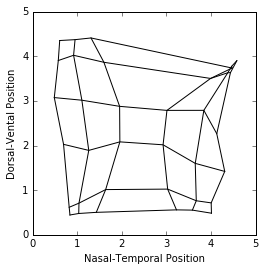

In [25]:
plot_map(rf_centres)